In [1]:
import pyximport
pyximport.install()

import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import dgl
import higra as hg
import higra as hg
from functools import partial
from scipy.cluster.hierarchy import fcluster

import DRBin
import DRBin.utils as _vambtools
from DRBin.models import DGI, LogReg
from DRBin import process

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_cluster import radius_graph

from sklearn.preprocessing import normalize
import scipy.sparse as sp

%matplotlib inline

Using backend: pytorch


ModuleNotFoundError: No module named 'gcn'

In [2]:
with open('/home/maog/data/metahit/contigs.fna', 'rb') as filehandle:
    tnfs, contignames, lengths = DRBin.parsecontigs.read_contigs(filehandle)
rpkms = np.load('/home/maog/data/metahit/abundance.npz')
rpkms=rpkms['arr_0']
vae = DRBin.encode.VAE(nsamples=rpkms.shape[1])
dataloader, mask = DRBin.encode.make_dataloader(rpkms, tnfs)
#vae.trainmodel(dataloader)
#latent = vae.encode(dataloader)
#np.savetxt('/home/maog/data/metahit/hit_latent.txt', latent)
latent = np.loadtxt('/home/maog/data/metahit/hit_latent.txt')

In [42]:
batch = torch.zeros(latent.shape[0])
latent = torch.tensor(latent)
edge_index = radius_graph(latent, r=10, loop=False)
u, v = edge_index[0], edge_index[1]
g = dgl.graph((u, v))
bg = dgl.to_bidirected(g)
knn_graph = bg.adj(scipy_fmt='csr')
sp.save_npz('/home/maog/data/metahit/hitG.npz', knn_graph)

In [6]:
# training params
batch_size = 1
nb_epochs = 5000
patience = 20
lr = 0.001
l2_coef = 0.0
drop_prob = 0.3
hid_units = 32
sparse = True
nonlinearity = 'prelu' # special name to separate parameters
features = latent
adj = sp.load_npz('/home/maog/data/metahit/hitG.npz')

features = sp.csr_matrix(features)
features, _ = process.preprocess_features(features)
nb_nodes = features.shape[0]
ft_size = features.shape[1]
adj = process.normalize_adj(adj + sp.eye(adj.shape[0]))

if sparse:
    sp_adj = process.sparse_mx_to_torch_sparse_tensor(adj)
else:
    adj = (adj + sp.eye(adj.shape[0])).todense()

features = torch.FloatTensor(features[np.newaxis])
if not sparse:
    adj = torch.FloatTensor(adj[np.newaxis])
model = DGI(ft_size, hid_units, nonlinearity)
optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_coef)

if torch.cuda.is_available():
    print('Using CUDA')
    model.cuda()
    features = features.cuda()
    if sparse:
        sp_adj = sp_adj.cuda()
    else:
        adj = adj.cuda()
b_xent = nn.BCEWithLogitsLoss()
xent = nn.CrossEntropyLoss()
cnt_wait = 0
best = 1e9
best_t = 0

for epoch in range(nb_epochs):
    model.train()
    optimiser.zero_grad()

    idx = np.random.permutation(nb_nodes)
    shuf_fts = features[:, idx, :]

    lbl_1 = torch.ones(batch_size, nb_nodes)
    lbl_2 = torch.zeros(batch_size, nb_nodes)
    lbl = torch.cat((lbl_1, lbl_2), 1)

    if torch.cuda.is_available():
        shuf_fts = shuf_fts.cuda()
        lbl = lbl.cuda()
    
    logits = model(features, shuf_fts, sp_adj if sparse else adj, sparse, None, None, None) 

    loss = b_xent(logits, lbl)

    #print('Loss:', loss)

    if loss < best:
        best = loss
        best_t = epoch
        cnt_wait = 0
        torch.save(model.state_dict(), '/test_data/best_dgi.pkl')
    else:
        cnt_wait += 1

    loss.backward()
    optimiser.step()

model.load_state_dict(torch.load('/test_data/best_dgi.pkl'))
embeds, _ = model.embed(features, sp_adj if sparse else adj, sparse, None)
embeds = embeds.squeeze(-3).cpu()
embeds = embeds.numpy()

a = 0.73
#get the final vector for clustering
X = (a * features + (1 - a) * embeds)

NameError: name 'AvgReadout' is not defined

In [ ]:
#clustering
from DRBin.ultrametric.optimization import UltrametricFitting
from DRBin.ultrametric.data import load_datasets, show_datasets
from DRBin.ultrametric.graph import build_graph, show_graphs
from DRBin.ultrametric.utils import Experiments
from DRBin.ultrametric.evaluation import eval_clustering

from DRBin.ultrametric.loss import loss_closest, loss_closest_and_cluster_size, make_triplets, loss_closest_and_triplet, loss_dasgupta


In [ ]:
methods = {
    'average': lambda X, graph, edge_weights: hg.binary_partition_tree_average_linkage(graph, edge_weights),
    'ward': lambda X, graph, edge_weights: hg.binary_partition_tree_ward_linkage(graph, X)
}

n_clusters = 10000
A = build_graph(X, 'mst')
graph, edge_weights = hg.adjacency_matrix_2_undirected_graph(A)
method = methods['average']
loss = partial(loss_closest_and_cluster_size, top_nodes=10)
optim = UltrametricFitting(500, 0.1, loss)
ultrametric = optim.fit(graph, edge_weights)
hierarchy = hg.bpt_canonical(graph, ultrametric)
Z = hg.binary_hierarchy_to_scipy_linkage_matrix(*hierarchy)
y_prediction = fcluster(Z, n_clusters, criterion='maxclust') - 1
np.savetxt('result.txt', y_prediction, fmt='%d')

In [16]:
result = np.loadtxt('/home/maog/bishe/GCNBin/DRBin/hc_result.txt', dtype=int)
filtered_labels = [n for (n,m) in zip(contignames, mask) if m]
result2 = dict()
for i in range(lengths.shape[0]):
    if (result[i] != -1):
        result2[result[i]] = filtered_labels[i]

In [17]:
import collections
cluster = dict()
cluster = collections.defaultdict(set)
for i in range(lengths.shape[0]):
    if (result[i] != -1): 
        cluster[result2[result[i]]].add(filtered_labels[i])

In [18]:
def filterclusters(clusters, lengthof):
    filtered_bins = dict()
    for medoid, contigs in clusters.items():
        binsize = sum(lengthof[contig] for contig in contigs)
    
        if binsize >= 200000:
            filtered_bins[medoid] = contigs
    
    return filtered_bins
lengthof = dict(zip(contignames, lengths))
filtered_bins = filterclusters(DRBin.utils.binsplit(cluster, 'C'), lengthof)
print('Number of bins before splitting and filtering:', len(cluster))
print('Number of bins after splitting and filtering:', len(filtered_bins))

Number of bins before splitting and filtering: 10000
Number of bins after splitting and filtering: 900


In [28]:
# This writes a .tsv file with the clusters and corresponding sequences
with open('/home/maog/data/oral/result/hc_cluster.tsv', 'w') as file:
    DRBin.utils.write_clusters(file, filtered_bins)

# Only keep contigs in any filtered bin in memory
keptcontigs = set.union(*filtered_bins.values())

with open('/home/maog/data/oral/contigs.fna', 'rb') as file:
    fastadict = DRBin.utils.loadfasta(file, keep=keptcontigs)
    
bindir = '/home/maog/data/oral/result/bins'
DRBin.utils.write_bins(bindir, filtered_bins, fastadict, maxbins=1000)

In [ ]:
# First load in the Reference
reference_path = '/home/maog/data/oral/reference.tsv'

!head $reference_path # show first 10 lines of reference file

with open(reference_path) as reference_file:
    reference = DRBin.benchmark.Reference.from_file(reference_file)

In [ ]:
taxonomy_path = '/home/maog/data/oral/taxonomy.tsv'

!head $taxonomy_path # show first 10 lines of reference file

with open(taxonomy_path) as taxonomy_file:
    reference.load_tax_file(taxonomy_file)

In [29]:
with open('/home/maog/data/oral/result/hc_cluster.tsv') as clusters_file:
    DRBin_clusters = DRBin.utils.read_clusters(clusters_file)
    DRBin_bins = DRBin.benchmark.Binning(DRBin_clusters, reference, minsize=100000)

In [30]:
print('DRBin bins:')
for rank in DRBin_bins.summary():
    print('\t'.join(map(str, rank)))

DRBin bins:
225	222	208	198	182	168	147	123	84
137	137	135	133	129	123	109	88	61
69	69	69	67	66	62	59	50	38


In [31]:
with open('/home/maog/data/oral/vamb_cluster.tsv') as clusters_file:
    vamb_clusters = DRBin.utils.read_clusters(clusters_file)
    vamb_bins = DRBin.benchmark.Binning(vamb_clusters, reference, minsize=100000)

In [32]:
print('vamb bins:')
for rank in vamb_bins.summary():
    print('\t'.join(map(str, rank)))

vamb bins:
207	199	189	180	169	157	136	112	82
139	138	135	131	127	121	103	85	60
70	70	70	67	66	63	56	48	37


In [37]:
recalls = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
vambbins = []
DRBins = []
j = 0
for i in recalls:
    vambbins.append(vamb_bins.counters[j][(i, 0.95)])
    DRBins.append(DRBin_bins.counters[j][(i, 0.95)])

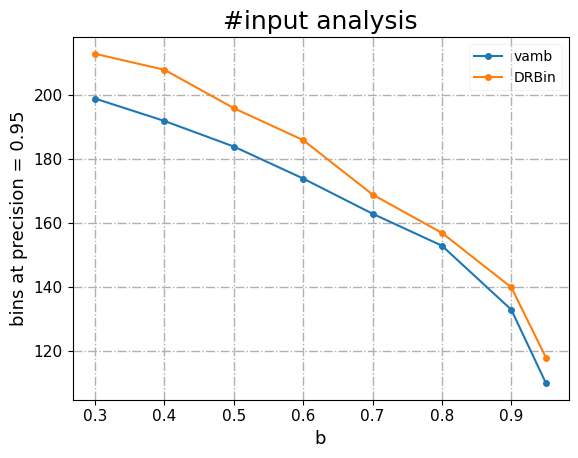

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig,ax=plt.subplots(figsize=(6.4,4.8), dpi=100)
recalls = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
ax.plot(recalls,vambbins, label='vamb', linestyle='-', marker='o', markersize='4')
ax.plot(recalls,DRBins, label='DRBin', linestyle='-', marker='o', markersize='4')
plt.title('#input analysis', fontsize=18)
ax.set_xlabel('b', fontsize=13)
ax.set_ylabel('bins at precision = 0.95', fontsize=13)
ax.tick_params(axis='both', labelsize=11)
ax.grid(True, linestyle='-.', linewidth = 1)
legend = ax.legend(loc='best', framealpha=0.2)